# Assignment 7: Regression and Regularization

In assignment 7 we identify the principal components in a dataset that tracked patients with Parkinson's Disease.

### Preparation

Import required libraries:

In [134]:
# Import required libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats as ss
import seaborn as sns

Define global options:

In [21]:
# Display plots inline
%matplotlib inline

# Display all outputs from cell
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

Declare functions:

In [136]:
# Perform scaling of column
def scale(col):
    mean_col = np.mean(col)
    sd_col = np.std(col)
    std = (col - mean_col) / sd_col
    return std

# Create inverse singular value matrix for singular values greater than cutoff
def set_D(s, cutoff=0.01):
    d = []
    for sv in s:
        if(sv > cutoff * s[0]): d.append(1.0/sv)
        else: d.append(0.0)
    return np.diag(d)

# Plot residual distribution
def plot_resid_dist(resids):
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))
    ## Plot a histogram
    sns.distplot(resids, bins=20, ax=ax[0])
    ax[0].set_title('Histogram of residuals')
    ax[0].set_xlabel('Residual values')
    ## Plot the Q-Q Normal plot
    ss.probplot(resids, plot = ax[1])
    ax[1].set_title('Q-Q Normal plot of residuals')
    plt.show()

# Plot residuals
def residual_plot(df):
    RMSE = np.std(df.resids)
    sns.scatterplot(x='predicted', y='resids', data=df)
    plt.axhline(0.0, color='red', linewidth=1.0)
    plt.axhline(2.0*RMSE, color='red', linestyle='dashed', linewidth=1.0)
    plt.axhline(-2.0*RMSE, color='red', linestyle='dashed', linewidth=1.0)
    plt.title('PLot of residuals vs. predicted')
    plt.xlabel('Predicted values')
    plt.ylabel('Residuals')
    plt.show()  

### Load the Data Set

We begin by loading the data set containing our dataset of patients with Parkinson's Disease:

In [58]:
# Internet location of the data set
url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/parkinsons/telemonitoring/parkinsons_updrs.data'

# Download the data into a dataframe object
parkinsons_data = pd.read_csv(url)

parkinsons_data

,subject#,age,sex,test_time,motor_UPDRS,total_UPDRS,Jitter(%),Jitter(Abs),Jitter:RAP,Jitter:PPQ5,...,Shimmer(dB),Shimmer:APQ3,Shimmer:APQ5,Shimmer:APQ11,Shimmer:DDA,NHR,HNR,RPDE,DFA,PPE
0,1,72,0,5.6431,28.199,34.398,0.00662,0.000034,0.00401,0.00317,...,0.230,0.01438,0.01309,0.01662,0.04314,0.014290,21.640,0.41888,0.54842,0.16006
1,1,72,0,12.6660,28.447,34.894,0.00300,0.000017,0.00132,0.00150,...,0.179,0.00994,0.01072,0.01689,0.02982,0.011112,27.183,0.43493,0.56477,0.10810
2,1,72,0,19.6810,28.695,35.389,0.00481,0.000025,0.00205,0.00208,...,0.181,0.00734,0.00844,0.01458,0.02202,0.020220,23.047,0.46222,0.54405,0.21014
3,1,72,0,25.6470,28.905,35.810,0.00528,0.000027,0.00191,0.00264,...,0.327,0.01106,0.01265,0.01963,0.03317,0.027837,24.445,0.48730,0.57794,0.33277
4,1,72,0,33.6420,29.187,36.375,0.00335,0.000020,0.00093,0.00130,...,0.176,0.00679,0.00929,0.01819,0.02036,0.011625,26.126,0.47188,0.56122,0.19361
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5870,42,61,0,142.7900,22.485,33.485,0.00406,0.000031,0.00167,0.00168,...,0.160,0.00973,0.01133,0.01549,0.02920,0.025137,22.369,0.64215,0.55314,0.21367
5871,42,61,0,149.8400,21.988,32.988,0.00297,0.000025,0.00119,0.00147,...,0.215,0.01052,0.01277,0.01904,0.03157,0.011927,22.886,0.52598,0.56518,0.12621
5872,42,61,0,156.8200,21.495,32.495,0.00349,0.000025,0.00152,0.00187,...,0.244,0.01371,0.01456,0.01877,0.04112,0.017701,25.065,0.47792,0.57888,0.14157
5873,42,61,0,163.7300,21.007,32.007,0.00281,0.000020,0.00128,0.00151,...,0.131,0.00693,0.00870,0.01307,0.02078,0.007984,24.422,0.56865,0.56327,0.14204


### Create the Feature Matrix

Create feature matrix for the features to examine, treating the *sex* column as *is_female*:

In [59]:
# Extract features
select_cols = ['age','sex','motor_UPDRS','total_UPDRS',
               'Jitter(%)','Jitter(Abs)','Jitter:RAP','Jitter:PPQ5','Jitter:DDP',
               'Shimmer','Shimmer(dB)','Shimmer:APQ3','Shimmer:APQ5','Shimmer:APQ11','Shimmer:DDA',
               'NHR','HNR','RPDE','DFA','PPE']

# Populate feature array, treat 'sex' column as 'is_female'
X = parkinsons_data.loc[:,select_cols]

# Display raw features
X

,age,sex,motor_UPDRS,total_UPDRS,Jitter(%),Jitter(Abs),Jitter:RAP,Jitter:PPQ5,Jitter:DDP,Shimmer,Shimmer(dB),Shimmer:APQ3,Shimmer:APQ5,Shimmer:APQ11,Shimmer:DDA,NHR,HNR,RPDE,DFA,PPE
0,72,0,28.199,34.398,0.00662,0.000034,0.00401,0.00317,0.01204,0.02565,0.230,0.01438,0.01309,0.01662,0.04314,0.014290,21.640,0.41888,0.54842,0.16006
1,72,0,28.447,34.894,0.00300,0.000017,0.00132,0.00150,0.00395,0.02024,0.179,0.00994,0.01072,0.01689,0.02982,0.011112,27.183,0.43493,0.56477,0.10810
2,72,0,28.695,35.389,0.00481,0.000025,0.00205,0.00208,0.00616,0.01675,0.181,0.00734,0.00844,0.01458,0.02202,0.020220,23.047,0.46222,0.54405,0.21014
3,72,0,28.905,35.810,0.00528,0.000027,0.00191,0.00264,0.00573,0.02309,0.327,0.01106,0.01265,0.01963,0.03317,0.027837,24.445,0.48730,0.57794,0.33277
4,72,0,29.187,36.375,0.00335,0.000020,0.00093,0.00130,0.00278,0.01703,0.176,0.00679,0.00929,0.01819,0.02036,0.011625,26.126,0.47188,0.56122,0.19361
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5870,61,0,22.485,33.485,0.00406,0.000031,0.00167,0.00168,0.00500,0.01896,0.160,0.00973,0.01133,0.01549,0.02920,0.025137,22.369,0.64215,0.55314,0.21367
5871,61,0,21.988,32.988,0.00297,0.000025,0.00119,0.00147,0.00358,0.02315,0.215,0.01052,0.01277,0.01904,0.03157,0.011927,22.886,0.52598,0.56518,0.12621
5872,61,0,21.495,32.495,0.00349,0.000025,0.00152,0.00187,0.00456,0.02499,0.244,0.01371,0.01456,0.01877,0.04112,0.017701,25.065,0.47792,0.57888,0.14157
5873,61,0,21.007,32.007,0.00281,0.000020,0.00128,0.00151,0.00383,0.01484,0.131,0.00693,0.00870,0.01307,0.02078,0.007984,24.422,0.56865,0.56327,0.14204


The result is the raw feature matrix with unscaled values.

### Scale the Feature Matrix

First we scale the features to compare them by a common reference point:

In [125]:
# Columns that we scale
scale_cols = ['age',
              'Jitter(%)','Jitter(Abs)','Jitter:RAP','Jitter:PPQ5','Jitter:DDP',
              'Shimmer','Shimmer(dB)','Shimmer:APQ3','Shimmer:APQ5','Shimmer:APQ11','Shimmer:DDA',
              'NHR','HNR','RPDE','DFA','PPE']

# Create new scaled DataFrame
scaled_data = pd.DataFrame()

# Categorical feature(s)
scaled_data.loc[:,'is_female'] = parkinsons_data.loc[:,'sex']

# Scale the feature columns for accurate comparison
for col in scale_cols:
    scaled_data.loc[:,col] = scale(parkinsons_data.loc[:,col])

# Display scaled data
scaled_data

,is_female,age,Jitter(%),Jitter(Abs),Jitter:RAP,Jitter:PPQ5,Jitter:DDP,Shimmer,Shimmer(dB),Shimmer:APQ3,Shimmer:APQ5,Shimmer:APQ11,Shimmer:DDA,NHR,HNR,RPDE,DFA,PPE
0,0,0.815695,0.082905,-0.284242,0.327453,-0.028637,0.328505,-0.324594,-0.351642,-0.209709,-0.423356,-0.543466,-0.209704,-0.298721,-0.009205,-1.214066,-1.478500,-0.650658
1,0,0.815695,-0.560793,-0.756723,-0.533746,-0.476212,-0.534825,-0.534016,-0.573156,-0.545158,-0.565592,-0.529955,-0.545153,-0.351965,1.282650,-1.055119,-1.247880,-1.218585
2,0,0.815695,-0.238944,-0.539382,-0.300038,-0.320767,-0.298983,-0.669115,-0.564469,-0.741592,-0.702426,-0.645545,-0.741587,-0.199370,0.318711,-0.784860,-1.540139,-0.103280
3,0,0.815695,-0.155370,-0.485186,-0.344859,-0.170682,-0.344871,-0.423692,0.069668,-0.460540,-0.449763,-0.392849,-0.460787,-0.071754,0.644530,-0.536487,-1.062115,1.237075
4,0,0.815695,-0.498557,-0.663894,-0.658604,-0.529814,-0.659682,-0.658276,-0.586186,-0.783145,-0.651413,-0.464905,-0.783392,-0.343370,1.036305,-0.689195,-1.297953,-0.283954
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5870,0,-0.431361,-0.372307,-0.358449,-0.421694,-0.427970,-0.422773,-0.583565,-0.655681,-0.561024,-0.528983,-0.600010,-0.560767,-0.116990,0.160696,0.997028,-1.411923,-0.064697
5871,0,-0.431361,-0.566128,-0.537436,-0.575365,-0.484252,-0.574309,-0.421369,-0.416793,-0.501338,-0.442561,-0.422372,-0.501081,-0.338311,0.281189,-0.153430,-1.242097,-1.020641
5872,0,-0.431361,-0.473663,-0.537158,-0.469717,-0.377049,-0.469728,-0.350143,-0.290834,-0.260328,-0.335135,-0.435882,-0.260576,-0.241573,0.789028,-0.629379,-1.048856,-0.852755
5873,0,-0.431361,-0.594579,-0.658336,-0.546552,-0.473532,-0.547630,-0.743051,-0.781639,-0.772568,-0.686822,-0.721104,-0.772815,-0.404372,0.639170,0.269141,-1.269038,-0.847618


### Singular Value Decomposition Linear Regression

Compute an inverse of the model matrix and use this to estimate the model parameters:

In [126]:
# Compute the inverse of the model matrix
U, s, V = np.linalg.svd(scaled_data, full_matrices=False)

# Display singular values
print('\nThe singular values from the SVD are \n{}:'.format(s))


The singular values from the SVD are 
[257.2916268  100.11802605  86.48832918  76.80625443  65.61808088  43.84933399  41.7523206   34.37323664  31.45449112  29.82598126  24.18161643  15.65593228  10.90350177   9.04793163   7.13491274   5.11877251   0.0471103    0.01106652]:


Note that there are some very small singular values, which we plot for a better understanding:

Text(0.5, 1.0, 'Singular values vs singular value number')

Text(0, 0.5, 'Singular value')

Text(0.5, 0, 'Singular value number')

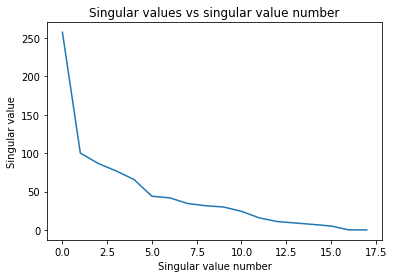

In [127]:
plt.plot(s)
plt.title('Singular values vs singular value number')
plt.ylabel('Singular value')
plt.xlabel('Singular value number')

The last two values are practically zero, while six other values below 17.0 are quite small relative to the first value. We will set the inverse of values below a cutoff of 0.5 to zero and create the inverse singular value matrix:

In [128]:
D = set_D(s)
np.round(D,3)

array([[0.004, 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ],
       [0.   , 0.01 , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ],
       [0.   , 0.   , 0.012, 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ],
       [0.   , 0.   , 0.   , 0.013, 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ],
       [0.   , 0.   , 0.   , 0.   , 0.015, 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ],
       [0.   , 0.   , 0.   , 0.   , 0.   , 0.023, 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ],
       [0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.024, 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ],
       [0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   

Now compute the pseudo inverse of the model matrix and estimage model parameters by multiplying the pseudo inverse by the label column:

In [129]:
MP_inverse = np.dot(V, np.dot(D, np.transpose(U)))
b = np.dot(MP_inverse, parkinsons_data.motor_UPDRS)
b

array([ -2.77443028,  10.18277264,   1.8712299 ,  -2.77746685,   0.52982232,   2.08448323,  -1.55229221,   5.71172834, -12.08328861,   9.5594654 ,  -7.1455289 ,   8.33842258,  -3.25132868, -14.70956191,  -5.34037076,   6.80361492,  -3.24823374,   8.19517781])

The coefficients are of a similar order of magnitude though perhaps not as close as we might like.

### Model Evaluation

We now evaluate the model with the goal of predicting the label column *motor_UPDRS*.

In [130]:
# Compute and display predicted values
scaled_data.loc[:,'predicted'] = np.dot(scaled_data, b)
motor_scale = np.std(parkinsons_data.motor_UPDRS)
motor_mean = np.mean(parkinsons_data.motor_UPDRS)
print('The mean actual motor UPDRS = {}   STD = {}\n'.format(motor_mean, motor_scale))
scaled_data.loc[:,'predicted'] = np.multiply(motor_scale, scaled_data.loc[:,'predicted'])
scaled_data.loc[:,'predicted'] = np.add(motor_mean,  scaled_data.loc[:,'predicted'])

# Add label
scaled_data.loc[:,'motor_UPDRS'] = parkinsons_data.loc[:,'motor_UPDRS']

# Display results
scaled_data.loc[:10,['motor_UPDRS','predicted']]

The mean actual motor UPDRS = 21.296228544680908   STD = 8.128589640865574



,motor_UPDRS,predicted
0,28.199,54.408143
1,28.447,-25.948276
2,28.695,78.177942
3,28.905,108.134381
4,29.187,59.225984
5,29.435,135.709876
6,29.682,92.834942
7,29.928,94.192137
8,30.177,122.487902
9,30.424,113.433247


Clearly the predicted values are quite far off. To diagnose we examine the distribution of predicted and actual motor UPDRS values:

Mean of predicted values = 14.129425614717558
STD of predicted values = 154.2756281347142



Text(0.5, 1.0, 'Distribution of predicted motor UPDRS')

Text(0.5, 0, 'Height')

(-990.9039685786098, 562.4821216944093)

Text(0.5, 1.0, 'Distribution of actual motor UPDRS')

Text(0.5, 0, 'Height')

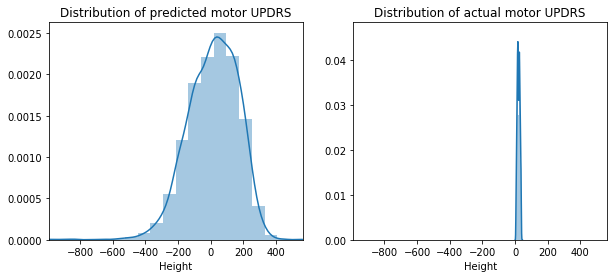

In [132]:
xmin = min(min(scaled_data.predicted), min(scaled_data.motor_UPDRS))
xmax = max(max(scaled_data.predicted), max(scaled_data.motor_UPDRS))
print('Mean of predicted values = {}'.format(np.mean(scaled_data.predicted)))
print('STD of predicted values = {}\n'.format(np.std(scaled_data.predicted)))

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))
sns.distplot(scaled_data.predicted, bins=20, ax=ax[0])
ax[0].set_title('Distribution of predicted motor UPDRS')
ax[0].set_xlabel('Height')
ax[0].set_xlim(xmin,xmax)
sns.distplot(scaled_data.motor_UPDRS, bins=20, ax=ax[1])
ax[1].set_title('Distribution of actual motor UPDRS')
ax[1].set_xlabel('Height')
_=ax[1].set_xlim(xmin,xmax)

The distributions are nowhere close. The actual motor UPDRS hardly varies, but the predicted values are all over the place with STD of 154!

Now we examine the residuals:

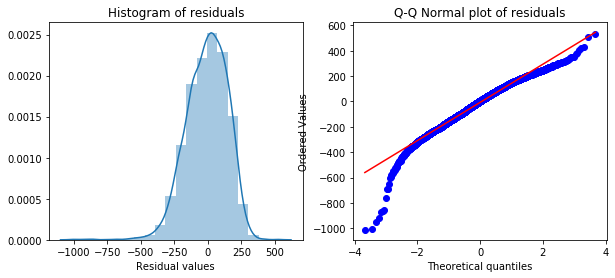

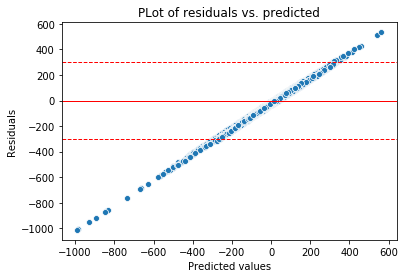

In [135]:
# Plot 
scaled_data.loc[:,'resids'] = np.subtract(scaled_data.loc[:,'predicted'],scaled_data.loc[:,'motor_UPDRS'])
plot_resid_dist(scaled_data.loc[:,'resids'])
residual_plot(scaled_data)

The residuals are approximately normal but strongly heteroscedastic, suggesting that the mean value is a better predictor than the model.

Now we compute summary metrics on the regression:

In [137]:
SSR = np.sum(np.square(scaled_data.loc[:,'resids']))
SST = np.sum(np.square(scaled_data.loc[:,'motor_UPDRS'] - height_mean))

print('SSR: {}'.format(SSR))
print('SST: {}'.format(SST))

R2 = 1.0 - (SSR / SST)

print('R-squared = {}'.format(R2))

SSR: 136238817.8637
SST: 388184.571103823
R-squared = -349.96402073966476


The metrics reveal how far off the model is, with R-squared in the hundreds rather than approaching zero as we'd prefer.

### Derive the Covariance Matrix

Now we derive the covariance matrix of the features (the design matrix) from the scaled feature matrix:

In [67]:
# Compute covariance matrix of features
C = np.dot(np.transpose(scaled_data),scaled_data)
C = np.multiply(1.0/float(scaled_data.shape[0]), C)
np.round(C,2)

array([[ 1.  , -0.04,  0.27,  0.31,  0.02,  0.04,  0.01,  0.01,  0.01,  0.1 ,  0.11,  0.1 ,  0.09,  0.14,  0.1 ,  0.01, -0.1 ,  0.09, -0.09,  0.12],
       [-0.04,  1.  , -0.03, -0.1 ,  0.05, -0.15,  0.08,  0.09,  0.08,  0.06,  0.06,  0.04,  0.06,  0.02,  0.04,  0.17, -0.  , -0.16, -0.17, -0.1 ],
       [ 0.27, -0.03,  1.  ,  0.95,  0.08,  0.05,  0.07,  0.08,  0.07,  0.1 ,  0.11,  0.08,  0.09,  0.14,  0.08,  0.07, -0.16,  0.13, -0.12,  0.16],
       [ 0.31, -0.1 ,  0.95,  1.  ,  0.07,  0.07,  0.06,  0.06,  0.06,  0.09,  0.1 ,  0.08,  0.08,  0.12,  0.08,  0.06, -0.16,  0.16, -0.11,  0.16],
       [ 0.02,  0.05,  0.08,  0.07,  1.  ,  0.87,  0.98,  0.97,  0.98,  0.71,  0.72,  0.66,  0.69,  0.65,  0.66,  0.83, -0.68,  0.43,  0.23,  0.72],
       [ 0.04, -0.15,  0.05,  0.07,  0.87,  1.  ,  0.84,  0.79,  0.84,  0.65,  0.66,  0.62,  0.62,  0.59,  0.62,  0.7 , -0.71,  0.55,  0.35,  0.79],
       [ 0.01,  0.08,  0.07,  0.06,  0.98,  0.84,  1.  ,  0.95,  1.  ,  0.68,  0.69,  0.65,  0.66,  0.6 , 

Note that several values off of the diagonal are close to 1.0 suggesting that the inverse is unstable. This is confirmed by examination of the eigenvalues:

In [68]:
L, Q = np.linalg.eig(C)
np.round(L,4)

array([11.2974,  2.1729,  1.6981,  1.4347,  0.8359,  0.798 ,  0.7097,  0.2935,  0.2066,  0.1694,  0.1486,  0.099 ,  0.0487,  0.0403,  0.0202,  0.0138,  0.0086,  0.0044,  0.    ,  0.    ])

The fact that nine of these eigenvalues are nearly zero suggests again that the inverse of the covariance matrix is unstable.

### Regularization

Now we introduce a small amount of bias to the covariance matrix to avoid destabilizing divide-by-zero scenarios:

In [69]:
alpha = 0.01
for i in range(C.shape[0]):
    C[i,i] = C[i,i] + alpha
np.round(C,2)

array([[ 1.01, -0.04,  0.27,  0.31,  0.02,  0.04,  0.01,  0.01,  0.01,  0.1 ,  0.11,  0.1 ,  0.09,  0.14,  0.1 ,  0.01, -0.1 ,  0.09, -0.09,  0.12],
       [-0.04,  1.01, -0.03, -0.1 ,  0.05, -0.15,  0.08,  0.09,  0.08,  0.06,  0.06,  0.04,  0.06,  0.02,  0.04,  0.17, -0.  , -0.16, -0.17, -0.1 ],
       [ 0.27, -0.03,  1.01,  0.95,  0.08,  0.05,  0.07,  0.08,  0.07,  0.1 ,  0.11,  0.08,  0.09,  0.14,  0.08,  0.07, -0.16,  0.13, -0.12,  0.16],
       [ 0.31, -0.1 ,  0.95,  1.01,  0.07,  0.07,  0.06,  0.06,  0.06,  0.09,  0.1 ,  0.08,  0.08,  0.12,  0.08,  0.06, -0.16,  0.16, -0.11,  0.16],
       [ 0.02,  0.05,  0.08,  0.07,  1.01,  0.87,  0.98,  0.97,  0.98,  0.71,  0.72,  0.66,  0.69,  0.65,  0.66,  0.83, -0.68,  0.43,  0.23,  0.72],
       [ 0.04, -0.15,  0.05,  0.07,  0.87,  1.01,  0.84,  0.79,  0.84,  0.65,  0.66,  0.62,  0.62,  0.59,  0.62,  0.7 , -0.71,  0.55,  0.35,  0.79],
       [ 0.01,  0.08,  0.07,  0.06,  0.98,  0.84,  1.01,  0.95,  1.  ,  0.68,  0.69,  0.65,  0.66,  0.6 , 

Let's examine the eigenvalues again:

In [70]:
L_regularized, Q = np.linalg.eig(C)
np.round(L_regularized,4)

array([11.3074,  2.1829,  1.7081,  1.4447,  0.8459,  0.808 ,  0.7197,  0.3035,  0.2166,  0.1794,  0.1586,  0.109 ,  0.0587,  0.0503,  0.0302,  0.0238,  0.0186,  0.0144,  0.01  ,  0.01  ])

After regularization no eigenvalues remain that are essentially zero.

We now verify that the new eigenvalues do not substantially differ from the original unbiased estimates:

In [71]:
np.round(np.subtract(L_regularized,L),3)

array([0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01])

Note that the difference in the eigenvalues is minimal and equal to the value of the bias added.

### Create and Plot the Principal Components

TODO

### SVD-Linear Regression with Singular Value Decomposition

Compute an inverse of the model matrix and use this to estimate the model parameters:

### Report

Report on: Number of components before and after (choose a smaller number of principal components and explain how you chose them). Interpret the adjusted R-squared.